# ⚡️ Energy Based Models

In this notebook, we'll walk through the steps required to train your own Energy Based Model to predict the distribution of a demo dataset

## Table of contents
0. [Parameters](#parameters)
1. [Prepare the Data](#prepare)
2. [Build the EBM](#build)
3. [Train the EBM](#train)
4. [Generate images](#generate)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn import datasets

import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp

from utils.image import display
from utils.datasets import sample_batch
import random

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

## 0. Parameters <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 32
CHANNELS = 1
STEP_SIZE = 10
STEPS = 60
NOISE = 0.005
ALPHA = 0.1
GRADIENT_CLIP = 0.03
BATCH_SIZE = 128
BUFFER_SIZE = 8192
LEARNING_RATE = 0.0001
EPOCHS = 60

In [4]:
# Load the data
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

In [5]:
# Preprocess the data

def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = (imgs.astype("float32") - 127.5) / 127.5
    imgs = np.pad(imgs , ((0,0), (2,2), (2,2)), constant_values= -1.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [6]:
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(BATCH_SIZE)
x_test = tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE)

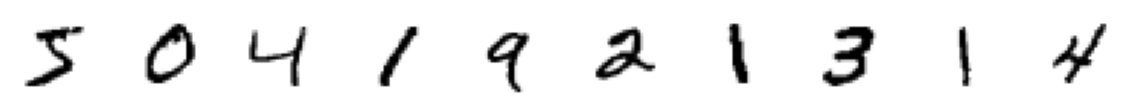

In [7]:
# Show some items of clothing from the training set
train_sample = sample_batch(x_train)
display(train_sample)

In [8]:
train_sample.shape

(128, 32, 32, 1)

In [9]:
ebm_input = keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = keras.layers.Conv2D(16, kernel_size=5, strides=2, padding="same", activation = keras.activations.swish)(ebm_input)
x = keras.layers.Conv2D(32, kernel_size=3, strides=2, padding="same", activation = keras.activations.swish)(x)
x = keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation = keras.activations.swish)(x)
x = keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation = keras.activations.swish)(x)
x =  keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation = keras.activations.swish)(x)
ebm_output = keras.layers.Dense(1)(x)
ebm_model = keras.Model(ebm_input, ebm_output)
ebm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 16)        416       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448 

In [10]:
class Sampler:
    def __init__(self, model, max_len=BUFFER_SIZE):
        super().__init__()
        self.model = model
        self.max_len = max_len
        self.examples = [tf.random.uniform(shape = (1, IMAGE_SIZE,IMAGE_SIZE,CHANNELS)) * 2 - 1 for _ in range(BATCH_SIZE)]
                         
    def sample_new_exmps(self, steps, step_size, noise):
        n_new = np.random.binomial(BATCH_SIZE, 0.05)
        rand_imgs = tf.random.uniform((n_new, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1
        old_imgs = tf.concat(random.choices(self.examples, k=BATCH_SIZE-n_new), axis=0)
        inp_imgs = tf.concat([rand_imgs, old_imgs], axis=0)
        inp_imgs = self.generate_samples(self.model, inp_imgs, steps=steps, step_size=step_size, noise = noise)
        self.examples = tf.split(inp_imgs, BATCH_SIZE, axis = 0) + self.examples
        self.examples = self.examples[:self.max_len]
        return inp_imgs

    @staticmethod
    def generate_samples(model, inp_imgs, steps, step_size, noise, return_img_per_step=False):
        imgs_per_step = []
        for _ in range(steps):
            inp_imgs += tf.random.normal(inp_imgs.shape, mean = 0, stddev = noise)
            inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
            with tf.GradientTape() as tape:
                tape.watch(inp_imgs)
                out_score = model(inp_imgs)
            grads = tape.gradient(out_score, inp_imgs)
            grads = tf.clip_by_value(grads, -GRADIENT_CLIP, GRADIENT_CLIP)
            inp_imgs += step_size * grads
            inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
            if return_img_per_step:
                imgs_per_step.append(inp_imgs)
        if return_img_per_step:
            return tf.stack(imgs_per_step, axis=0)
        else:
            return inp_imgs

In [11]:
class EBM(keras.Model):
    def __init__(self):
        super(EBM, self).__init__()
        self.cnn = ebm_model
        self.sampler = Sampler(self.cnn)
        self.alpha = ALPHA
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.reg_loss_metric = keras.metrics.Mean(name="reg")
        self.cdiv_loss_metric = keras.metrics.Mean(name="cdiv")
        self.real_out_metric = keras.metrics.Mean(name="real")
        self.fake_out_metric = keras.metrics.Mean(name="fake")
       
    @property
    def metrics(self):
        return [self.loss_metric, self.reg_loss_metric, self.cdiv_loss_metric, self.real_out_metric, self.fake_out_metric]
    
    def train_step(self, real_imgs):
        real_imgs += tf.random.normal(shape=tf.shape(real_imgs), mean = 0, stddev = NOISE)
        real_imgs = tf.clip_by_value(real_imgs, -1.0, 1.0)
        fake_imgs = self.sampler.sample_new_exmps(steps=STEPS, step_size=STEP_SIZE, noise = NOISE)
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        with tf.GradientTape() as training_tape:
            real_out, fake_out = tf.split(self.cnn(inp_imgs), 2, axis=0)
            reg_loss = self.alpha * tf.reduce_mean(real_out ** 2 + fake_out ** 2, axis = 0)
            cdiv_loss = tf.reduce_mean(fake_out, axis = 0) - tf.reduce_mean(real_out, axis = 0)
            loss = reg_loss + cdiv_loss
        grads = training_tape.gradient(loss, self.cnn.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.cnn.trainable_variables))
        self.loss_metric.update_state(loss)
        self.reg_loss_metric.update_state(reg_loss)
        self.cdiv_loss_metric.update_state(cdiv_loss)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis = 0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis = 0))
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, real_imgs):
        batch_size = real_imgs.shape[0]
        fake_imgs = tf.random.uniform((batch_size, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        real_out, fake_out = tf.split(self.cnn(inp_imgs), 2, axis=0)
        cdiv = tf.reduce_mean(fake_out, axis = 0) - tf.reduce_mean(real_out, axis = 0)
        self.cdiv_loss_metric.update_state(cdiv)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis = 0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis = 0))
        return {m.name: m.result() for m in self.metrics[2:]}
        

In [12]:
ebm = EBM()

## 3. Train the EBM network <a name="train"></a>

In [13]:
# Compile and train the model
ebm.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), run_eagerly=True)

In [14]:
# Create a model save checkpoint
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

In [22]:
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")

In [23]:
class ImageGenerator(keras.callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        start_imgs = np.random.uniform(size = (self.num_img,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)) * 2 - 1
        generated_images = Sampler.generate_samples(ebm.cnn, start_imgs, steps=256, step_size=STEP_SIZE, noise = NOISE, return_img_per_step=False)
        generated_images = generated_images.numpy()
        display(generated_images, save_to = "./output/generated_img_%03d.png" % (epoch))
        
        example_images = tf.concat(random.choices(ebm.sampler.examples, k = 10), axis = 0)
        example_images = example_images.numpy()
        display(example_images, save_to = "./output/example_img_%03d.png" % (epoch))

image_generator_callback = ImageGenerator(num_img=10)

In [ ]:
ebm.fit(
    # np.array([x_train[0] for _ in range(5000)] + [x_train[1] for _ in range(5000)])
    x_train
    , batch_size=BATCH_SIZE
    , shuffle = True
    , epochs=60
    # , steps_per_epoch = 10
    , initial_epoch = 39
    , validation_data = x_test
    , callbacks = [model_checkpoint_callback, tensorboard_callback, image_generator_callback]
)

Epoch 40/60
  4/469 [..............................] - ETA: 4:23 - loss: -0.0026 - reg: 7.5538e-05 - cdiv: -0.0027 - real: 0.0048 - fake: 0.0021

## 4. Generate images <a name="generate"></a>

In [ ]:
start_imgs = np.random.uniform(size = (10,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)) * 2 - 1

In [ ]:
display(start_imgs)

In [ ]:
gen_img = Sampler.generate_samples(ebm.cnn, start_imgs, steps=200, step_size=10, noise = 0.005, return_img_per_step=False)

In [ ]:
display(gen_img.numpy())